In [1]:
from fastai.data.all import *
from fastai.vision.all import *
import torch
import ipywidgets as widgets
from fastai.vision.widgets import *

In [2]:
path = untar_data(URLs.MNIST)
path

Path('D:/Users/anupam/.fastai/data/mnist_png')

In [3]:
db_mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                    get_items=get_image_files,
                    splitter=GrandparentSplitter(train_name="training", valid_name="testing"),
                    get_y=parent_label)

In [4]:
# calculate the mean and std dev of training image data
from torchvision import transforms

to_tensor = transforms.ToTensor()
img_train = [to_tensor(img) for img, label in db_mnist.datasets(path/'training')]
img_train_stack = torch.stack(img_train, dim=3)
img_train_stack_1d = img_train_stack.view(1, -1)
img_mean = img_train_stack_1d.mean(dim=1)
img_stdev = img_train_stack_1d.std(dim = 1)
print(f"Mean = {img_mean}, Std. dev. = {img_stdev}")

Mean = tensor([0.1307]), Std. dev. = tensor([0.3081])


In [5]:
import os
os.getcwd()

'd:\\Anupam_Technical\\Code\\ML\\DeepLearning\\fastai\\MnistPlayground'

In [6]:
# Approach 2
# create a data block with the required transforms in place
norm_tfm = Normalize.from_stats(img_mean, img_stdev)

db_mnist_norm = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                    get_items=get_image_files,
                    splitter=GrandparentSplitter(train_name="training", valid_name="testing"),
                    get_y=parent_label,
                    batch_tfms=norm_tfm)

dl_mnist = db_mnist_norm.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


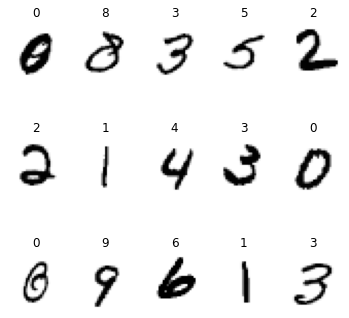

In [7]:
dl_mnist.show_batch(max_n=15, figsize=(6,6))

In [8]:
imgs, labels = dl_mnist.one_batch()
print(imgs.shape, labels.shape)
# Flatten is a nn.Module in fastai that is used to reshape tensors. In our case
# input image tensor of 1, 28, 28 dimension is flattened to 1d tensor of 784
flt = Flatten()
flt(imgs).shape    

torch.Size([64, 1, 28, 28]) torch.Size([64])


torch.Size([64, 784])

## Train a custom pytorch model first using fastai

In [9]:
ds_mnist = db_mnist.datasets(path)

In [10]:
ds_mnist.vocab

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

When we first take the softmax, and then the log likelihood of that, that combination is called cross-entropy loss. In PyTorch, this is available as nn.CrossEntropyLoss (which, in practice, actually does log_softmax and then nll_loss):

In [11]:
import torch.nn as nn
import torch.optim as optim

mnist_model = nn.Sequential(Flatten(),
                      nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

print(mnist_model)
learning_rate = 0.01
# define the optimizer ( we choose mini batch gradient descent with momentum)
optimizer = optim.SGD(mnist_model.parameters(), lr=learning_rate, momentum=0.9)
# loss function
mnist_loss_fn = CrossEntropyLossFlat()

Sequential(
  (0): Flatten(full=False)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=10, bias=True)
)


SuggestedLRs(valley=0.02290867641568184)

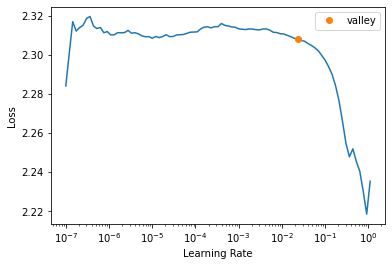

In [12]:
# If we specify a pytorch loss function to fastai learner, it causes assertion error while doing 
# interpretation using fastai library functions like plot_top_losses etc. You either use fastai
# provided loss functions like CrossEntropyLoss or don't specify the loss function
# https://forums.fast.ai/t/confusion-matrix-assert-error-on-mnist/81582/6
mnist_learner = Learner(dl_mnist, mnist_model, opt_func=SGD, loss_func=mnist_loss_fn, 
                        lr=learning_rate, metrics=accuracy) 
mnist_learner.lr_find()

In [19]:
mnist_learner.fit(n_epoch=10, lr=.022)

epoch,train_loss,valid_loss,accuracy,time
0,0.154775,0.153417,0.952000,03:51
1,0.118192,0.130272,0.961300,03:59
2,0.104849,0.114186,0.965800,03:51
3,0.094611,0.102218,0.968300,03:58
4,0.081112,0.093836,0.971700,03:51
5,0.077833,0.095263,0.971400,04:40
6,0.061076,0.085287,0.974900,02:18
7,0.058105,0.080745,0.976100,02:10
8,0.050496,0.082377,0.974700,02:04
9,0.046826,0.076786,0.976100,02:09


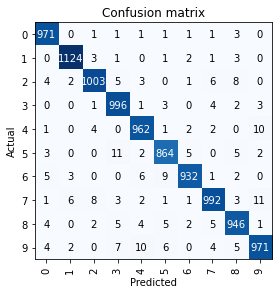

In [20]:
interp = ClassificationInterpretation.from_learner(mnist_learner)
interp.plot_confusion_matrix()

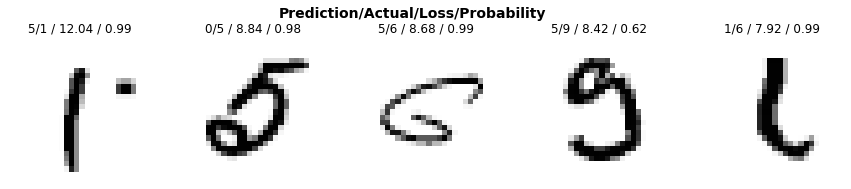

In [21]:
interp.plot_top_losses(5, nrows=1)

## Let us use a pretrained model and see how transfer learning improves the accuracy

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


SuggestedLRs(valley=0.002511886414140463)

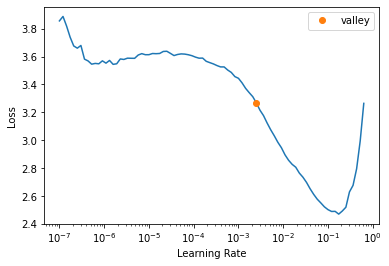

In [22]:
fnames = get_image_files(path)
def label_func(x): return x.parent.name
dls_mnist_new = ImageDataLoaders.from_path_func(path, fnames, label_func, seed=42, batch_tfms=norm_tfm)
learn = cnn_learner(dls_mnist_new, resnet34, metrics=accuracy, loss_func=F.cross_entropy)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.577775,0.403075,0.870071,02:29


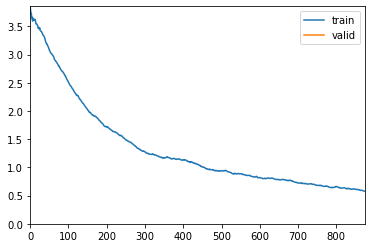

epoch,train_loss,valid_loss,accuracy,time
0,0.128989,0.081206,0.974643,02:17
1,0.072594,0.055088,0.983000,02:12
2,0.055603,0.042034,0.986929,02:06
3,0.032063,0.041303,0.987857,02:14
4,0.036710,0.031031,0.990571,02:12
5,0.023803,0.029665,0.992286,02:12
6,0.016559,0.031849,0.991571,02:09
7,0.009950,0.029536,0.992143,02:03
8,0.010254,0.026898,0.993429,02:04
9,0.003487,0.027462,0.993786,02:08


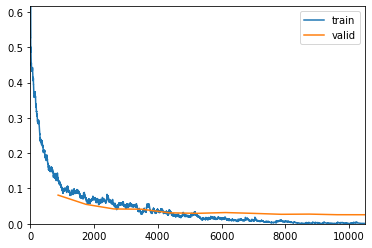

In [23]:
learn.fine_tune(12, base_lr=0.0021, cbs=[ShowGraphCallback()])

In [ ]:
learn.save('mnist_resnet34')

In [ ]:
interp_tl = ClassificationInterpretation.from_learner(learn)
interp_tl.plot_confusion_matrix()

In [ ]:
interp_tl.plot_top_losses(5, nrows=1)